In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-10-06 12:55:25.592059: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-06 12:55:27.111505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-10-06 12:55:27.111725: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-10-06 12:55:27.113065: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-10-06 12:55:27.114241: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-10-06 12:55:27.114519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-10-06 12:55:27.115958: I tensorflow/stream_executor

In [3]:
#Setting up training and testing data:
mean_1 = [0, 1, 0, 0, 0]
cov_1 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_2 = [1, 0, 0, 0, 0]
cov_2 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_3 = [0,0,1,0,0]
cov_3 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]


x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
y_1 = np.random.multivariate_normal(mean_1, cov_1, size=100000)

x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
y_2 = np.random.multivariate_normal(mean_2, cov_2, size=100000)

x_3 = np.random.multivariate_normal(mean_3, cov_3, size=1000000)
y_3 = np.random.multivariate_normal(mean_3, cov_3, size=100000)


In [4]:
print(x_1[0])

[ 2.55987032  1.81338639 -0.42120624 -0.05556975  0.82785025]


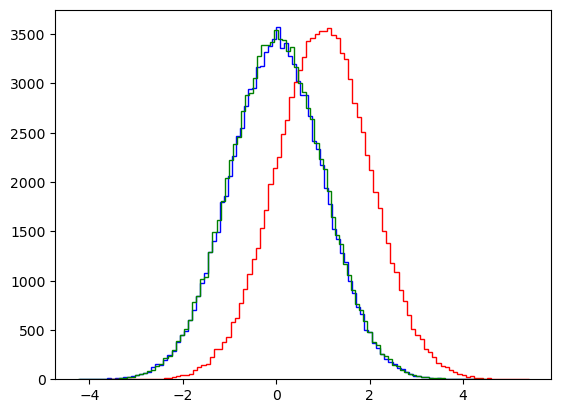

In [5]:
plt.hist(y_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step')
plt.hist(y_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step')
plt.hist(y_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step')
plt.show()

In [6]:
#Preparing three samples
n_samples = 3
n_dom = 100000
n_sub = 2500

sample_1_1_train = x_1[0:n_dom]
#Using one-hot encoding here
true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_1_1_train)[0]).reshape(np.shape(sample_1_1_train)[0],n_samples)

sample_1_2_train = x_2[0:n_sub]
true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_1_2_train)[0]).reshape(np.shape(sample_1_2_train)[0],n_samples)
sample_1_3_train = x_3[0:n_sub]
true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_1_3_train)[0]).reshape(np.shape(sample_1_3_train)[0],n_samples)

sample_2_1_train = x_1[n_dom:n_sub+n_dom]
#Using one-hot encoding here
true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_2_1_train)[0]).reshape(np.shape(sample_2_1_train)[0],n_samples)

sample_2_2_train = x_2[n_sub:n_sub + n_dom]
true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_2_2_train)[0]).reshape(np.shape(sample_2_2_train)[0],n_samples)
sample_2_3_train = x_3[n_sub:n_sub+n_sub]
true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_2_3_train)[0]).reshape(np.shape(sample_2_3_train)[0],n_samples)

sample_3_1_train = x_1[n_sub+n_dom:n_sub+n_sub+n_dom]
#Using one-hot encoding here
true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_3_1_train)[0]).reshape(np.shape(sample_3_1_train)[0],n_samples)

sample_3_2_train = x_2[n_sub+n_dom:n_sub+n_sub+n_dom]
true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_3_2_train)[0]).reshape(np.shape(sample_3_2_train)[0],n_samples)
sample_3_3_train = x_3[n_sub+n_sub:n_sub+n_sub+n_dom]
true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_3_3_train)[0]).reshape(np.shape(sample_3_3_train)[0],n_samples)






In [7]:
x_test = np.concatenate((y_1,y_2,y_3))
y_test_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(y_1)[0]).reshape(np.shape(y_1)[0],n_samples)
y_test_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(y_2)[0]).reshape(np.shape(y_2)[0],n_samples)
y_test_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(y_3)[0]).reshape(np.shape(y_3)[0],n_samples)
y_test = np.concatenate((y_test_1, y_test_2, y_test_3))

In [8]:
y_test = np.argmax(y_test, axis = 1)

In [9]:
print(y_test)

[0 0 0 ... 2 2 2]


Three samples three-classes approach

In [10]:
rng = np.random.default_rng()
x_train_1 = np.concatenate((sample_1_1_train, sample_1_2_train, sample_1_3_train))
y_train_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(x_train_1)[0]).reshape(np.shape(x_train_1)[0],n_samples)
true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                               true_label_sample_1_3_train))
indices_1 = rng.permutation(np.shape(x_train_1)[0])

x_shuffle_1 = x_train_1[indices_1]
y_shuffle_1 = y_train_1[indices_1]
true_label_shuffle_1 = true_label_1[indices_1]

x_train_2 = np.concatenate((sample_2_1_train, sample_2_2_train, sample_2_3_train))
y_train_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(x_train_2)[0]).reshape(np.shape(x_train_2)[0],n_samples)
true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                               true_label_sample_2_3_train))
indices_2 = rng.permutation(np.shape(x_train_2)[0])

x_shuffle_2 = x_train_2[indices_2]
y_shuffle_2 = y_train_2[indices_2]
true_label_shuffle_2 = true_label_2[indices_2]

x_train_3 = np.concatenate((sample_3_1_train, sample_3_2_train, sample_3_3_train))
y_train_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(x_train_3)[0]).reshape(np.shape(x_train_3)[0],n_samples)
true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                               true_label_sample_3_3_train))
indices_3 = rng.permutation(np.shape(x_train_3)[0])

x_shuffle_3 = x_train_3[indices_3]
y_shuffle_3 = y_train_3[indices_3]
true_label_shuffle_3 = true_label_3[indices_3]


Code from Feng-Yang:

In [21]:
def build_model(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [22]:
x_train = np.concatenate((x_shuffle_1, x_shuffle_2, x_shuffle_3))
y_train = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
true_label_train = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

y_train = np.argmax(y_train, axis = 1)
true_label_train = np.argmax(true_label_train, axis = 1)

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]

model = build_model(x_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
history = model.fit(x_train, y_train, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])

Train on 252000 samples, validate on 63000 samples
Epoch 1/50
252000/252000 [==============================] - 1s 5us/sample - loss: 0.8738 - accuracy: 0.6023 - val_loss: 0.8607 - val_accuracy: 0.6123
Epoch 2/50
252000/252000 [==============================] - 1s 4us/sample - loss: 0.8619 - accuracy: 0.6107 - val_loss: 0.8609 - val_accuracy: 0.6117
Epoch 3/50
252000/252000 [==============================] - 1s 4us/sample - loss: 0.8620 - accuracy: 0.6109 - val_loss: 0.8613 - val_accuracy: 0.6105
Epoch 4/50
252000/252000 [==============================] - 1s 4us/sample - loss: 0.8617 - accuracy: 0.6114 - val_loss: 0.8642 - val_accuracy: 0.6083
Epoch 5/50
252000/252000 [==============================] - 1s 4us/sample - loss: 0.8616 - accuracy: 0.6113 - val_loss: 0.8604 - val_accuracy: 0.6111
Epoch 6/50
252000/252000 [==============================] - 1s 4us/sample - loss: 0.8612 - accuracy: 0.6117 - val_loss: 0.8613 - val_accuracy: 0.6110
Epoch 7/50
252000/252000 [=======================

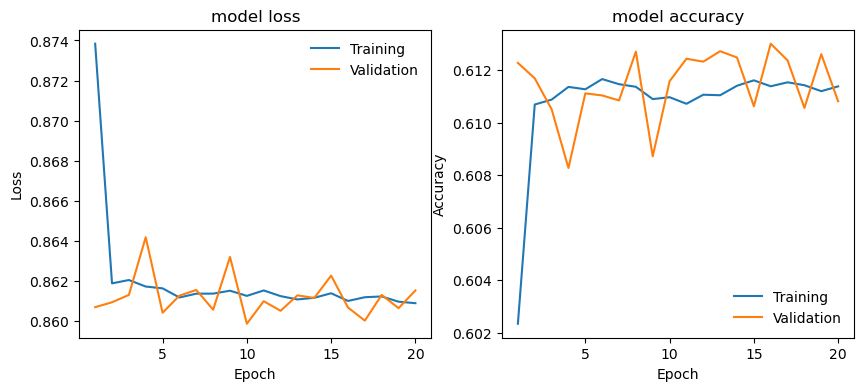

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

x = range(1, len(history.history['loss']) + 1)

ax[0].plot(x, history.history['loss'], label='Training')
ax[0].plot(x, history.history['val_loss'], label='Validation')

ax[0].legend(frameon=False)
ax[0].set_title(f'model loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(x, history.history['accuracy'], label='Training')
ax[1].plot(x, history.history['val_accuracy'], label='Validation')

ax[1].legend(frameon=False)
ax[1].set_title(f'model accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

In [24]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(loss, accuracy)

0.8204271855163574 0.63242
